# Validation of SONIC paradigm for multi-compartmental approaches

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from PySONIC.utils import logger, bounds
from PySONIC.threshold import threshold
from PySONIC.neurons import getPointNeuron, passiveNeuron, MRGNode, SundtSegment
from PySONIC.plt import setNormalizer
from PySONIC.core import BilayerSonophore, AcousticDrive, ElectricDrive, PulsedProtocol

from ExSONIC.core import MRGFiber, SennFiber, UnmyelinatedFiber, IntracellularCurrent
from ExSONIC.core.benchmark import *
from ExSONIC.constants import THR_VM_DIV

logger.setLevel(logging.INFO)

## Parameters

In [3]:
root = 'benchmarkData'
nperax = 20
f_US = 500.   # kHz
freqs = np.logspace(np.log10(20.), np.log10(4000.), nperax)  # kHz

## Pre-step 1: mapping of acoustic amplitude to Cm oscillation range

Using a 32 nm radius sonophore at 500 kHz

 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 1.00kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: t = 0.02200 ms: criterion not met -> stopping after 10 cycles
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 1.44kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 2.07kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 2.98kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 4.28kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 6.16kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 8.86kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 12.74kPa, Q = 0.00 C/cm2
 16/07/2020 09:46:38: BilayerSonophore(32.0 nm): simulation @ f = 500kHz, A = 18.33kPa, Q = 0.00 C/

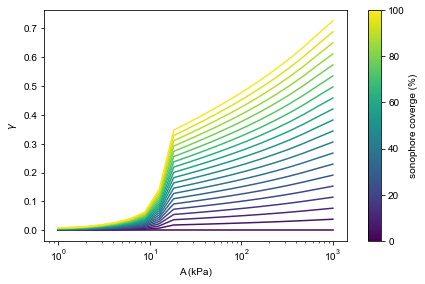

In [4]:
bls = BilayerSonophore(32e-9, 1e-2, 0.)
amps = np.logspace(3, np.log10(1e6), 20)  # Pa
Cm_ptp = np.empty(amps.size)
for i, A in enumerate(amps):
    data, meta = bls.simulate(AcousticDrive(f_US * 1e3, A), 0.)
    Cm_ptp[i] = np.ptp(bls.v_capacitance(data['Z']))

# Plot normalized Cm half oscillation range vs. acoustic amplitude for various coverages
coverages = np.linspace(0.0, 1.0, 20)
mymap = plt.get_cmap('viridis')
norm, sm = setNormalizer(mymap, bounds(coverages * 100), 'lin')
fig, ax = plt.subplots()
ax.set_xlabel('A (kPa)')
ax.set_ylabel('$\gamma$')
ax.set_xscale('log')
for fs in coverages:
    ax.plot(amps * 1e-3, Cm_ptp * fs / (2 * bls.Cm0), c=sm.to_rgba(fs * 100))
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.15, top=0.95, hspace=0.5)
cbarax = fig.add_axes([0.85, 0.15, 0.03, 0.8])
cbar = fig.colorbar(sm, cax=cbarax)
cbarax.set_ylabel(f'sonophore coverge (%)');

In [5]:
# Inteprolate max gamma and 100 kPa equivalent gamma for 100% sonophore coverage
gamma_full = Cm_ptp / (2 * bls.Cm0)
gamma_ub = np.ceil(max(gamma_full) * 10) / 10
gamma_default = np.round(np.interp(100e3, amps, gamma_full) * 10) / 10
gamma_pair = (gamma_default, 0)  # (-)
gammas = np.linspace(0.05, gamma_ub, nperax)  # (-)

## Pre-step 2: correct the MRG node to account for internodal leakage conductance

In the absence of juxtaposed internodes, the isolated MRG node membrane dynamics exhibits spontaneous activity, a behavior that prevents proper study of steady-state behavior and estimation of excitation thresholds.

To overcome this limitation, we design here a "corrected" MRG node that contains an additional internodal leakage current mimicking the influence of the neighboring indernode and to limit deviations from resting potential and eventually preventing spontaneous activity.

The reversal potential of this internodal leakage current is set to -80 mV (identical to the reversal of leakage currents in internodal sections), and its conductance is chosen that yields a similar node excitation threshold to a 100 us intracellular current pulse as that of a 10 um diameter fiber model.

In [6]:
def correctedMRGNode(g):

    class CorrectedMRGNode(MRGNode):

        name = 'corrected_MRGnode'
        gInter = g  # S/m2
        EInter = -80.0   # mV

        @classmethod
        def iInter(cls, Vm):
            ''' axial leakage current '''
            return cls.gInter * (Vm - cls.EInter)  # mA/m2

        @classmethod
        def currents(cls):
            ''' updated currents dictionary '''
            return {**MRGNode.currents(), 'iInter': lambda Vm, _: cls.iInter(Vm)}

    return CorrectedMRGNode

def isExcited(gInter, drive, pp):
    logger.info(f'simulation with gInter = {gInter:.2e} S/m2')
    pneuron = correctedMRGNode(gInter)()
    return pneuron.isExcited(pneuron.simulate(drive, pp)[0])

fiber = MRGFiber(10e-6, 11)
pp = PulsedProtocol(tstim=100e-6, toffset=3e-3)
Ithr = fiber.titrate(IntracellularCurrent(fiber.central_ID, None), pp)  # A
Am = fiber.nodes[fiber.central_ID].Am  # cm2
ithr = (Ithr * 1e3) / (Am * 1e-4)  # mA/m2
logger.info(f'Ithr = {Ithr * 1e9:.2f} nA, Am = {Am:.2e} cm2 -> ithr = {ithr:.2e} mA/m2')
drive = ElectricDrive(ithr)
gInter = threshold(lambda x: not isExcited(x, drive, pp), (1e-3, 1e6))
logger.info(f'Internodal conductance to match threshold: gInter = {gInter:.2e} S/m2')
corrected_MRGNode = correctedMRGNode(gInter)()

 16/07/2020 09:46:59: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=10.0pA, mode=anode), tstim = 100us, toffset = 3ms
 16/07/2020 09:47:00: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=20.0pA, mode=anode), tstim = 100us, toffset = 3ms
 16/07/2020 09:47:00: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=40.0pA, mode=anode), tstim = 100us, toffset = 3ms
 16/07/2020 09:47:01: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=80.0pA, mode=anode), tstim = 100us, toffset = 3ms
 16/07/2020 09:47:01: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=160.0pA, mode=anode), tstim = 100us, toffset = 3ms
 16/07/2020 09:47:01: MRGFiber(fiberD = 10.0 um, 11 nodes): simulation @ IntracellularCurrent(sec_id=node5, I=320.0pA, mode=anode), tstim = 100us, toffset = 3ms
 16/07/2020 09:47:02: MRGFiber(fiberD 

## Point-neurons and fiber models

In [7]:
pneurons = {
    'MRG': corrected_MRGNode,
    'Sundt': SundtSegment()
}

fibers = {
    'MRG': MRGFiber(10e-6, 11),
    'Sundt': UnmyelinatedFiber(0.8e-6)
}

## Benchmark 1: SONIC accuracy for a passive model as a function of membrane and axial properties

Using a passive model and a "typical" sinusoidal drive (f = 500 kHz, A_Cm = 0.8 * Cm0) and a passive model, we evaluate the divergence of the SONIC output from a cycle-averaged full output (measured as the absolute difference in steady-state charge densities normalized by resting capacitance (in mV) for a combination of:
- membrane time constant (tau_m = cm / gpas)
- "axial coupling time constant" (tau_ax = cm / ga).

Objective: establish trends of SONIC divergence as a function of model parameters
and identify "safe" regions for the SONIC approximation.

### Passive properties: peripheral fibers

In [8]:
gax = {k: fiber.ga_node_to_node * 1e4 for k, fiber in fibers.items()}  # S/m2
gm = {
    'MRG': corrected_MRGNode.gLeak + corrected_MRGNode.gInter,  # S/m2
    'Sundt': SundtSegment().gLeak  # S/m2
}

### Divergence map

In [ ]:
taum_range = np.logspace(-4, 1, nperax)   # ms
tauax_range = np.logspace(-4, 1, nperax)   # ms
pneuron = passiveNeuron(1e-2, 1e0, -70.0)
sb = SonicBenchmark(pneuron, 0., f_US, gamma_pair)
divmap = TauDivergenceMap(root, sb, 'end', taum_range, tauax_range)
divmap.run()
fig = divmap.render(interactive=True, dVmax=THR_VM_DIV)

# Add insets to represent fiber models
ax = fig.axes[0]
axis_to_data = ax.transAxes + ax.transData.inverted()
data_to_axis = axis_to_data.inverted()
xyoffset = {'MRG': np.array([0.1, 0.15]), 'Sundt': np.array([-0.1, 0.15])}
for k in fibers.keys():
    taum = pneurons[k].Cm0 / gm[k]   # s
    tauax = pneurons[k].Cm0 / gax[k]  # s
    xy = data_to_axis.transform((taum * 1e3, tauax * 1e3))
    ax.scatter(*xy, transform=ax.transAxes, facecolor='none', edgecolor='k', linestyle='--', lw=1);
    ax.annotate(k, xy=xy, xytext=np.array(xy) + xyoffset[k], xycoords=ax.transAxes,
                fontsize=12, arrowprops={'facecolor': 'black', 'arrowstyle': '-'},
                horizontalalignment='left' if xyoffset[k][0] > 0 else 'right');
for method in ['axvline', 'axhline']:
    getattr(ax, method)(1 / f_US, color='k', linestyle='--')

 16/07/2020 09:47:24: SonicBenchmark(pas_tau_1.00e-04ms dynamics, ga = 1.00e+04 mS/cm2, f = 500 kHz, rel A_Cm = (0.50, 0.00)): 0.01 ms simulation
 16/07/2020 09:47:24: taum = 1.00e-04 ms, tauax = 1.00e-04 ms, dV = 8.72e+00 mV
 16/07/2020 09:47:24: SonicBenchmark(pas_tau_1.00e-04ms dynamics, ga = 5.46e+03 mS/cm2, f = 500 kHz, rel A_Cm = (0.50, 0.00)): 0.01 ms simulation
 16/07/2020 09:47:24: taum = 1.00e-04 ms, tauax = 1.83e-04 ms, dV = 8.67e+00 mV
 16/07/2020 09:47:24: SonicBenchmark(pas_tau_1.00e-04ms dynamics, ga = 2.98e+03 mS/cm2, f = 500 kHz, rel A_Cm = (0.50, 0.00)): 0.01 ms simulation
 16/07/2020 09:47:24: taum = 1.00e-04 ms, tauax = 3.36e-04 ms, dV = 8.60e+00 mV
 16/07/2020 09:47:24: SonicBenchmark(pas_tau_1.00e-04ms dynamics, ga = 1.62e+03 mS/cm2, f = 500 kHz, rel A_Cm = (0.50, 0.00)): 0.01 ms simulation
 16/07/2020 09:47:24: taum = 1.00e-04 ms, tauax = 6.16e-04 ms, dV = 8.54e+00 mV
 16/07/2020 09:47:24: SonicBenchmark(pas_tau_1.00e-04ms dynamics, ga = 8.86e+02 mS/cm2, f = 500 

## Benchmark 2: SONIC accuracy for realistic bi-compartmental models as a function of drive parameters

Compute the average SONIC divergence for varying US frequencies and amplitude gradients, using full membrane dynamics and specific axial coupling magnitudes of specific neurons: 
- two nodes of Ranvier (MRG membrane dynamics with added leakage axial conductance mimicking the influence of internodal segments on membrane dynamics) of a myelinated fiber separated by a full internode
- two typical segments of an unmyelinated fiber (Sundt membrane dynamics) directly coupled

Objective: determine the drive parametric sub-space of SONIC applicability for each model.

In [20]:
def plotProfiles(pneuron, fiber, tstop):
    ga = fiber.ga_node_to_node * 1e3  # mS/cm2
    return SonicBenchmark(pneuron, ga, f_US, gamma_pair).simplot(tstop)
    
def plotDriveDivergenceMap(pneuron, fiber, tstop):
    ga = fiber.ga_node_to_node * 1e3  # mS/cm2
    sb = SonicBenchmark(pneuron, ga, f_US, gamma_pair)
    divmap = DriveDivergenceMap(root, sb, 'avg', freqs, gammas, tstop=tstop)
    divmap.run()
    return divmap.render(interactive=True, dVmax=THR_VM_DIV)

### MRG node

In [23]:
tstop = 3.0  # ms
sb = SonicBenchmark(pneurons['MRG'], fibers['MRG'].ga_node_to_node * 1e3, f_US, gamma_pair)
fig = sb.simplot(tstop)
divmap = DriveDivergenceMap(root, sb, 'avg', freqs, gammas, tstop=tstop)
divmap.run()
fig = divmap.render(interactive=True, dVmax=THR_VM_DIV)

### Sundt segment

 15/07/2020 21:34:07: SonicBenchmark(corrected_MRGnode dynamics, ga = 4.39e+02 mS/cm2, f = 500 kHz, rel A_Cm = (0.55, 0.00)): 3.00 ms simulation


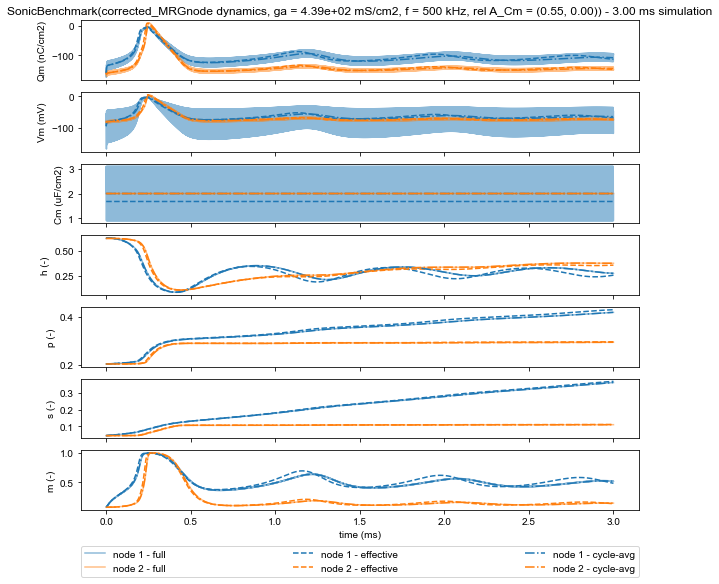

In [11]:
tstop = 10.0  # ms
sb = SonicBenchmark(pneurons['Sundt'], fibers['Sundt'].ga_node_to_node * 1e3, f_US, gamma_pair)
fig = sb.simplot(tstop)
divmap = DriveDivergenceMap(root, sb, 'avg', freqs, gammas, tstop=tstop)
divmap.run()
fig = divmap.render(interactive=True, dVmax=THR_VM_DIV)